# Cross-Domain Neural Networks for JPEG Decompression

This Jupyter Notebook tests cross-domain neural network models for JPEG decompression.

<a href=#data>Load Data</a>

<a href=#networka>Network A</a>: DCT-Image Domain W-net

<a href=#networkb>Network B</a>: DFT-Image Domain W-net

<a href=#networkc>Network C</a>: DCT-Image Domain Fully-Connected U-net

<a href=#networkd>Network D</a>: DFT-Image Domain Fully-Connected CNN

<a href=#scratchpad>Scratchpad</a>: Testing things

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.backend import eval as tf_eval
import skimage.measure as metrics

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
#from models import my_unet
#from cs_models import deep_cascade_unet_no_dc, deep_cascade_unet, deep_cascade_unet_ksp_no_dc,\
#dequantization_network, deep_cascade_fc_unet
from metrics import calculate_metrics
from dctools import dct_in_blocks, idct_in_blocks, py_dct2d, py_idct2d, get_quantization_matrix, \
extract_image_patches, compile_image_patches

Using TensorFlow backend.


# =============================================================
<a name='data'/>

In [3]:
# Network Parameters

H,W = 256, 256
norm = 128.0
compr_range = (10,20)

lr = 0.001

useDC = True

useImageNet = False

In [21]:
# Generate indexes to print the same images for each model
slc = 44

indexes_test = np.arange(len(test_images),dtype = int)
np.random.shuffle(indexes_test)
indexes_test = indexes_test[:3]

# Load Data

In [4]:
# Train and validation data paths

if useImageNet:
    images_path = "../../ImageNet/*.tif"
    images = glob.glob(images_path)
    print(len(images))
    # Listing train and validation images
    train_images = images[0:30000]
    val_images = images[30000:45000]
    test_images = images[45000:]

    # Summary of images
    print("Train set size:", len(train_images))
    print("Validation set size:",len(val_images))
    print("Test set size:",len(test_images))
    
else:
    # Train and validation data paths
    train_path = "../../MRDataset/Development/Training/*.tif"
    val_path = "../../MRDataset/Development/Validation/*.tif"
    test_path = "../../MRDataset/Testing/*.tif"

    # Listing train and validation images
    train_images = glob.glob(train_path)
    val_images = glob.glob(val_path)
    test_images = glob.glob(test_path)

    # Summary of images
    print("Train set size:", len(train_images))
    print("Validation set size:",len(val_images))
    print("Testing set size:",len(test_images))

Train set size: 10800
Validation set size: 5310
Testing set size: 16110


In [5]:
test_unc = np.zeros((len(test_images),H,W,1), dtype=np.float32)
test_compr = test_unc.copy()
test_qmat = test_unc.copy()

compr_test = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(test_images),replace = True)

# Test set
for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1, np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_test[ii]))
    im2 = Image.open(buf)
    test_compr[ii,:,:,0] = np.array(im2, np.float32)
    test_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))

norm_test_compr = test_compr - norm
norm_test_compr /= norm

test_qmat /= norm

In [7]:
metr = calculate_metrics(test_unc, test_compr)

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:206: RuntimeWarning: invalid value encountered in true_divide
  S = (A1 * A2) / D


removing 81 SSIM from list.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:206: RuntimeWarning: divide by zero encountered in true_divide
  S = (A1 * A2) / D


removing 148 SSIM from list.
removing 659 SSIM from list.
removing 990 SSIM from list.
removing 1383 SSIM from list.
removing 1400 SSIM from list.
removing 2144 SSIM from list.
removing 2927 SSIM from list.
removing 4234 SSIM from list.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


removing 4551 SSIM from list.
removing 4997 SSIM from list.
removing 5108 SSIM from list.
removing 5505 SSIM from list.
removing 5900 SSIM from list.
removing 5958 SSIM from list.
removing 6074 SSIM from list.
removing 6077 SSIM from list.
removing 6078 SSIM from list.
removing 6167 SSIM from list.
removing 6217 SSIM from list.
removing 6921 SSIM from list.
removing 6955 SSIM from list.
removing 7022 SSIM from list.
removing 7036 SSIM from list.
removing 7554 SSIM from list.
removing 7562 SSIM from list.
removing 7589 SSIM from list.
removing 7925 SSIM from list.
removing 8022 SSIM from list.
removing 8104 SSIM from list.
removing 8175 SSIM from list.
removing 8861 SSIM from list.
removing 9126 SSIM from list.
removing 9132 SSIM from list.
removing 9611 SSIM from list.
removing 9662 SSIM from list.
removing 9989 SSIM from list.
removing 10296 SSIM from list.
removing 10590 SSIM from list.
removing 11005 SSIM from list.
removing 11672 SSIM from list.
removing 11866 SSIM from list.
remov

# =============================================================
<a name='networka'/>

# Network A: DCT-Image Domain W-net

Two U-nets, first operating in the DCT domain and second in the image domain, are concatenated such that the result of the DCT-domain U-net is the input to the image-domain U-net in an end-to-end fashion.

Data consistency measures are taken by ensuring that the DCT coefficients predicted by either U-nets are not outside the allowed quantization values:

$$X_{reconstruction} \in [X_{JPEG} - \frac{Q}{2} , X_{JPEG} + \frac{Q}{2}]$$

where <br>
$X_{reconstruction}$ is the deep learning reconstructed image,<br>
$X_{JPEG}$ is the JPEG-decompressed image,<br>
$Q$ is the JPEG quality factor

In [24]:
opt=Adam(lr=lr)
model_name = "../Models/20190613-MRDataset-residual_wnet_di_data_augmentation_compress_10_20.hdf5"
model = deep_cascade_unet(depth_str='di')
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)
model.summary()

0 d
Append DCT layer
Append U-net block
Data consistency layer
Currently in the DCT domain
Append DC layer
Append iDCT layer
1 i
Append U-net block
Data consistency layer
Currently in the image domain
Append DCT-DC-iDCT layers
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 256, 256, 1)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 48) 480         lambda_9[0][0]                   
________________________________________________________________________________

In [25]:
pred = model.predict([norm_test_compr,test_qmat])

In [26]:
# Un-normalize

pred[0] *= norm
pred[0] += norm

pred[1] *= norm
pred[1] += norm

0.0 193.0
-0.83654785 173.18155


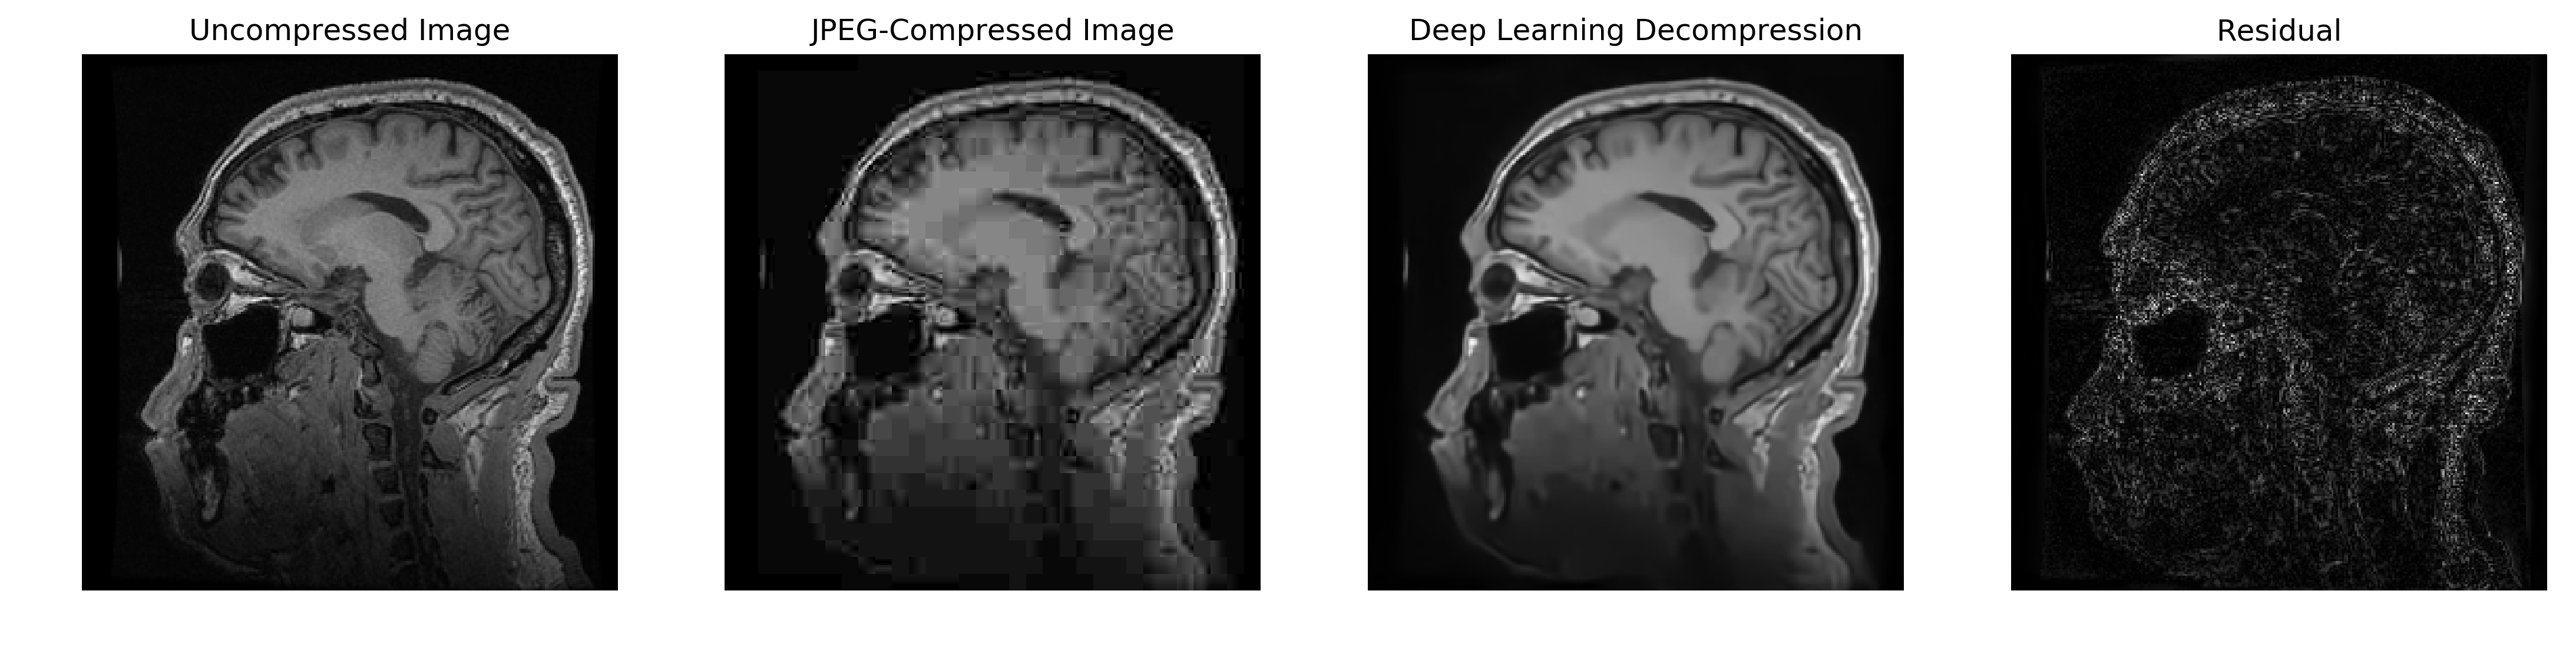

In [34]:
print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[0][slc,:,:,0]),np.max(pred[0][slc,:,:,0]))

plt.figure(figsize = (18,12),dpi=300)
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Deep Learning Decompression")
plt.imshow(pred[1][slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[0][slc,:,:,0]),cmap = "gray")
plt.show()

In [35]:
print(np.sum((pred[0][slc,:,:,0] - test_unc[slc,:,:,0])**2) / pred[0][slc,:,:,0].size)

41.30099105834961


Test set results


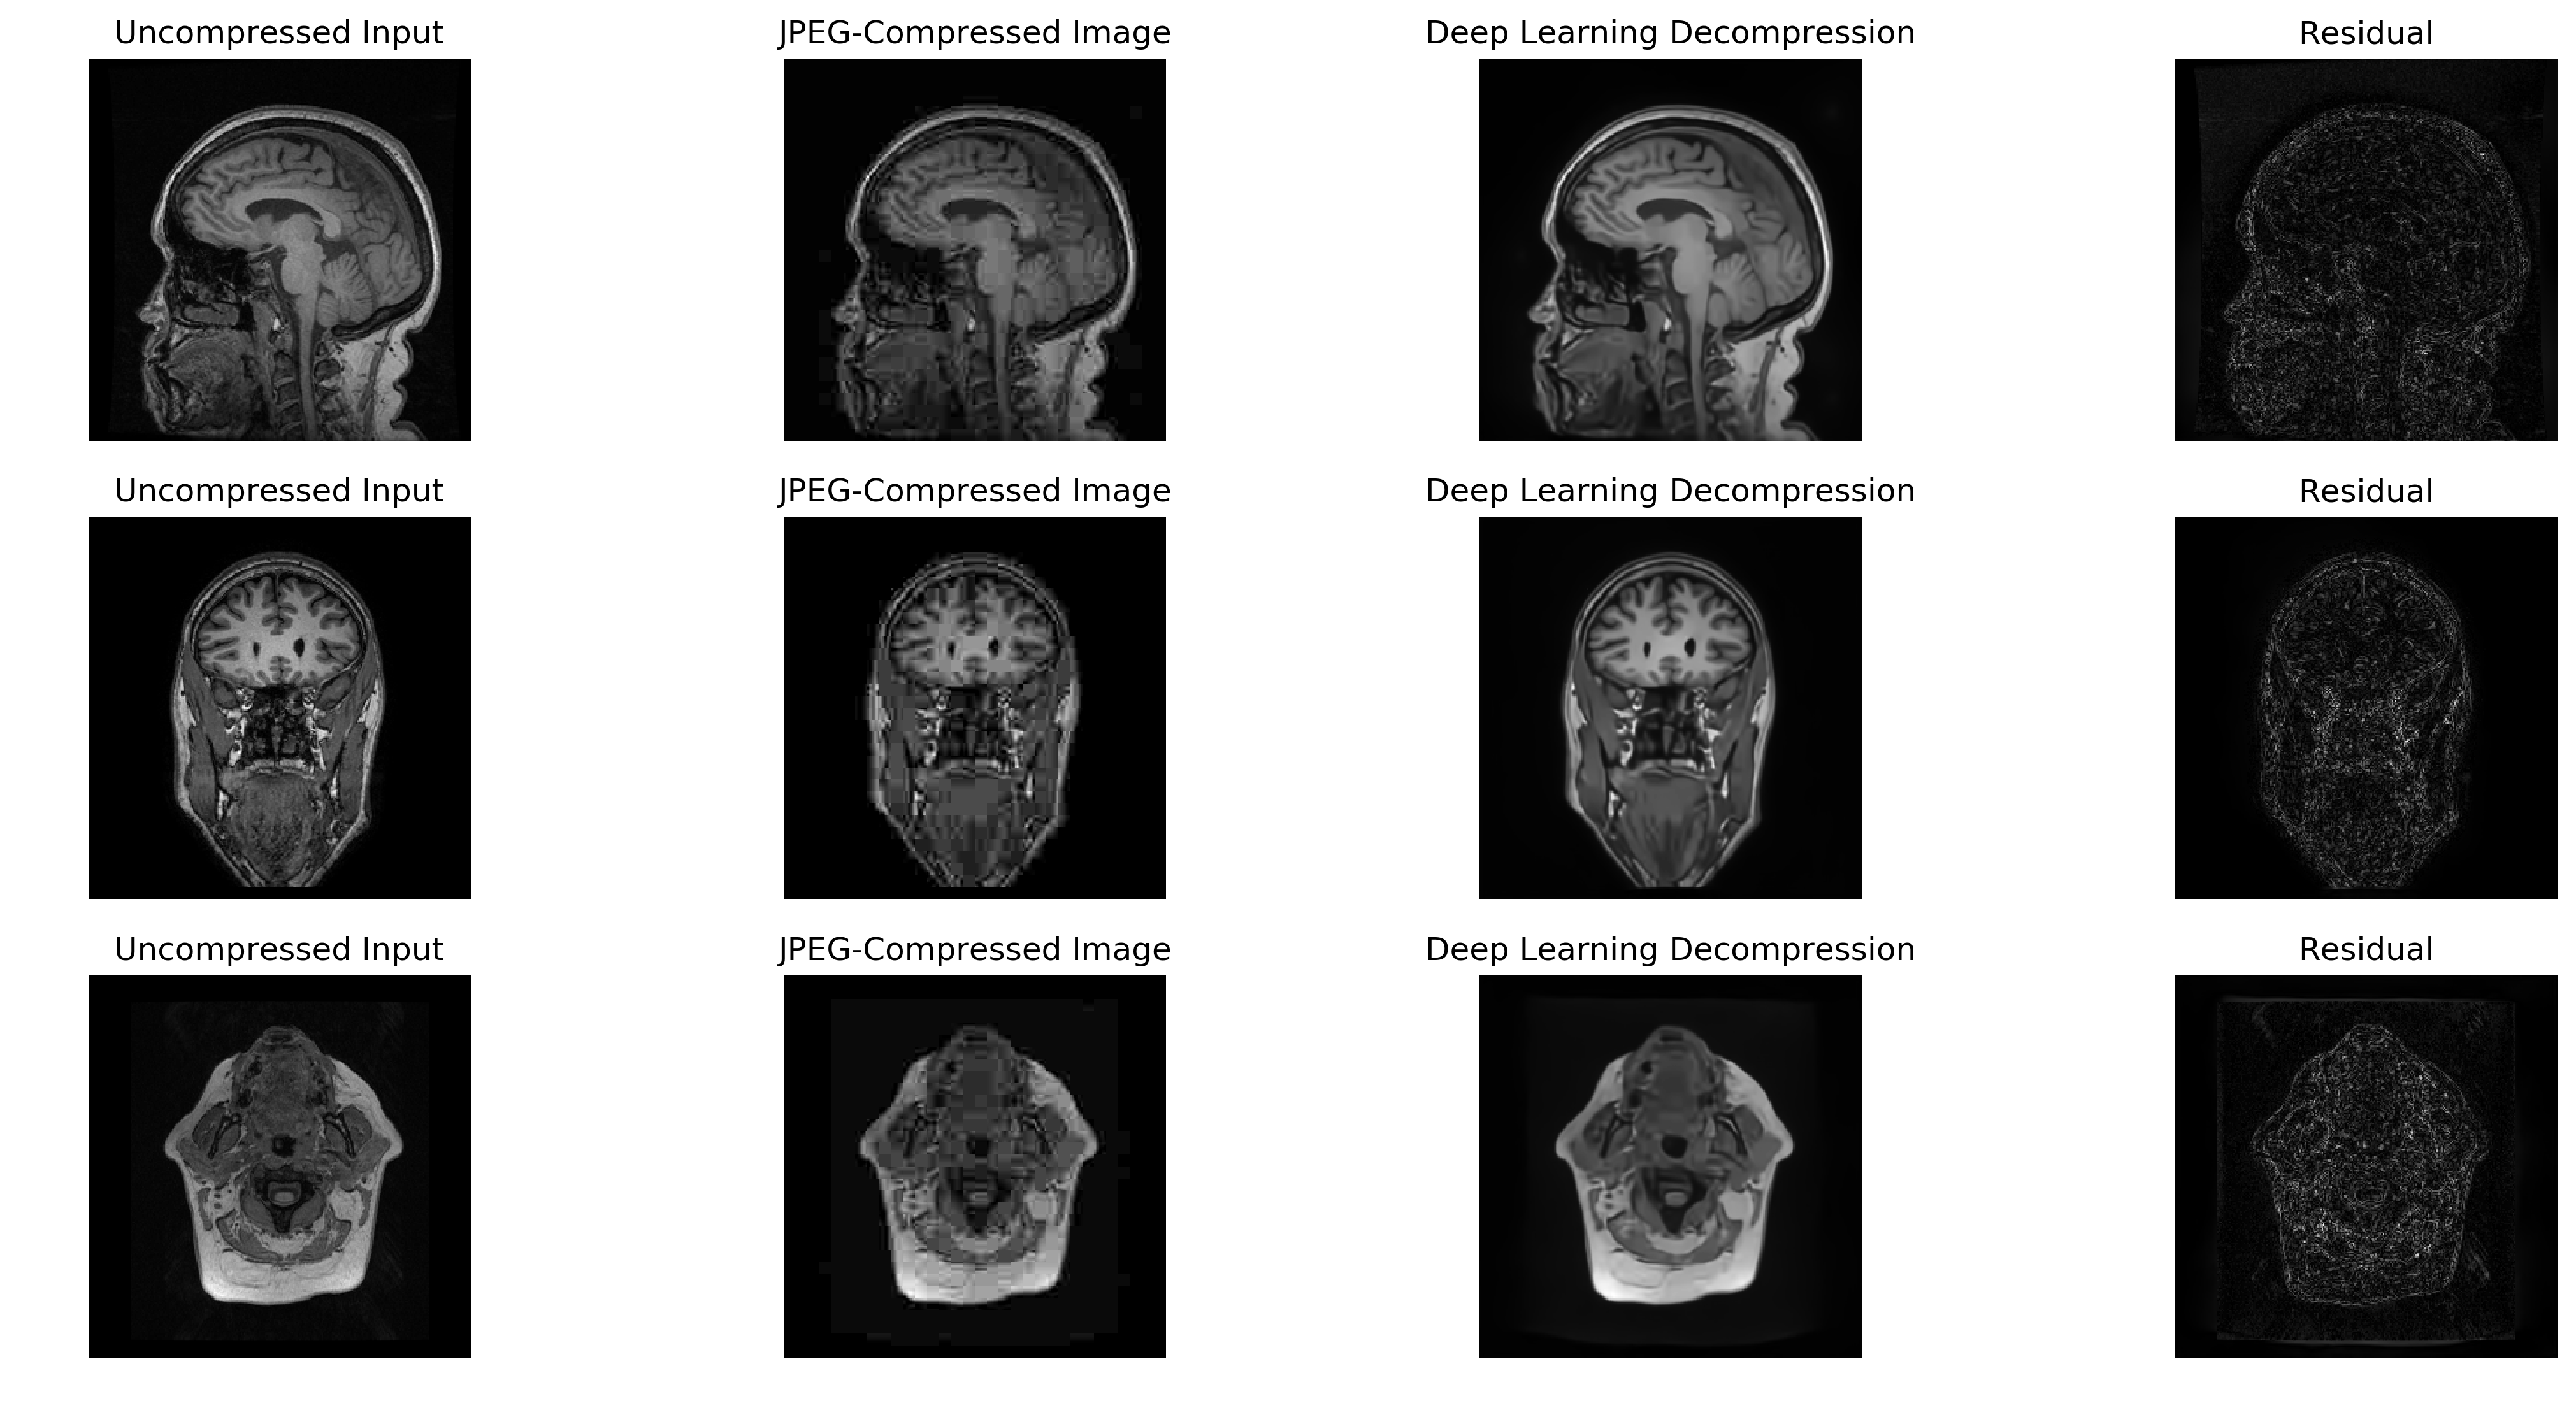

In [31]:
print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Input")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Image")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(pred[0][indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Deep Learning Decompression")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0]-pred[0][indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

In [30]:
metr = calculate_metrics(test_unc, pred[0])
print('\n')
metr = calculate_metrics(test_unc, pred[1])

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


removing 659 NRMSE from list.
removing 990 NRMSE from list.
removing 6077 NRMSE from list.
removing 6167 NRMSE from list.
removing 7022 NRMSE from list.
removing 7589 NRMSE from list.
removing 8104 NRMSE from list.
(16103, 3, 2)

Performance Metrics
SSIM: 0.811 +/- 0.118
PSNR: 29.970 +/- 2.764
NRMSE: 3.086 +/- 1.907


(16110, 3, 2)
removing 659 NRMSE from list.
removing 990 NRMSE from list.
removing 6077 NRMSE from list.
removing 6167 NRMSE from list.
removing 7022 NRMSE from list.
removing 7589 NRMSE from list.
removing 8104 NRMSE from list.
(16103, 3, 2)

Performance Metrics
SSIM: 0.817 +/- 0.105
PSNR: 30.002 +/- 2.625
NRMSE: 3.100 +/- 1.798


# =============================================================
<a name='networkb'/>

# Network B: DFT-Image Domain W-net

Two U-nets, first operating in the k-space and second in the image domain, are concatenated such that the result of the k-space (2-channel) U-net is the input to the image-domain (1-channel) U-net in an end-to-end fashion.

Data consistency measures are taken by ensuring that the DCT coefficients predicted by either U-nets are not outside the allowed quantization values:

$$X_{reconstruction} \in [X_{JPEG} - \frac{Q}{2} , X_{JPEG} + \frac{Q}{2}]$$

where: <br><br>
$X_{reconstruction}$ is the deep learning reconstructed image,<br>
$X_{JPEG}$ is the JPEG-decompressed image,<br>
$Q$ is the JPEG quality factor

In [17]:
opt=Adam(lr=lr)
model_name = "../Models/20190612-imagenet-residual_wnet_ki_data_augmentation_compress_10_20.hdf5"
model = deep_cascade_unet(depth_str='ki')
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)
model.summary()

0 k
Append rFFT layer
Append U-net block
Data consistency layer
Currently in the FFT domain
Append iFFT-abs layers
Append DCT-DC-iDCT layers
1 i
Append U-net block
Data consistency layer
Currently in the image domain
Append DCT-DC-iDCT layers
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 256, 256, 2)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 256, 256, 48) 912         lambda_7[0][0]                   
________________________________________________________________

In [18]:
pred = model.predict([norm_test_compr,test_qmat])

In [19]:
# Un-normalize

pred[0] *= norm
pred[0] += norm

pred[1] *= norm
pred[1] += norm

13.0 248.0
17.071823 244.14005


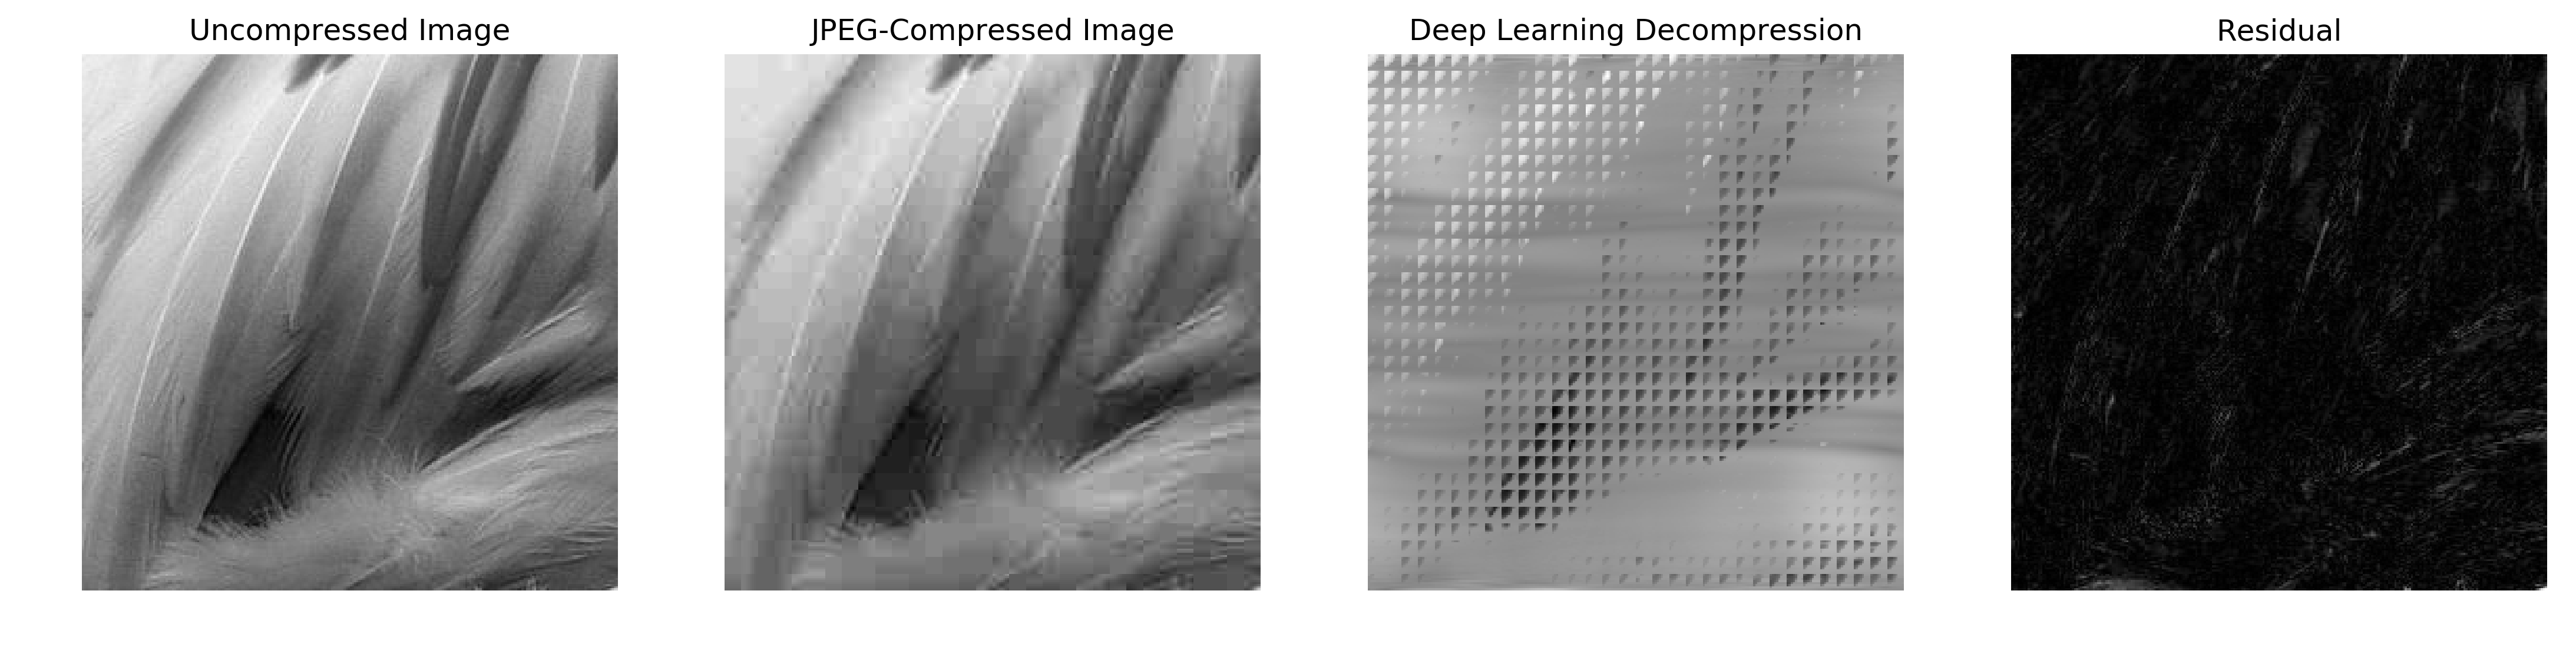

In [20]:
print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[0][slc,:,:,0]),np.max(pred[0][slc,:,:,0]))

plt.figure(figsize = (18,12),dpi=300)
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Deep Learning Decompression")
plt.imshow(pred[1][slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[0][slc,:,:,0]),cmap = "gray")
plt.show()

In [21]:
print(np.sum((pred[0][slc,:,:,0] - test_unc[slc,:,:,0])**2) / pred[0][slc,:,:,0].size)

50.22599792480469


Test set results


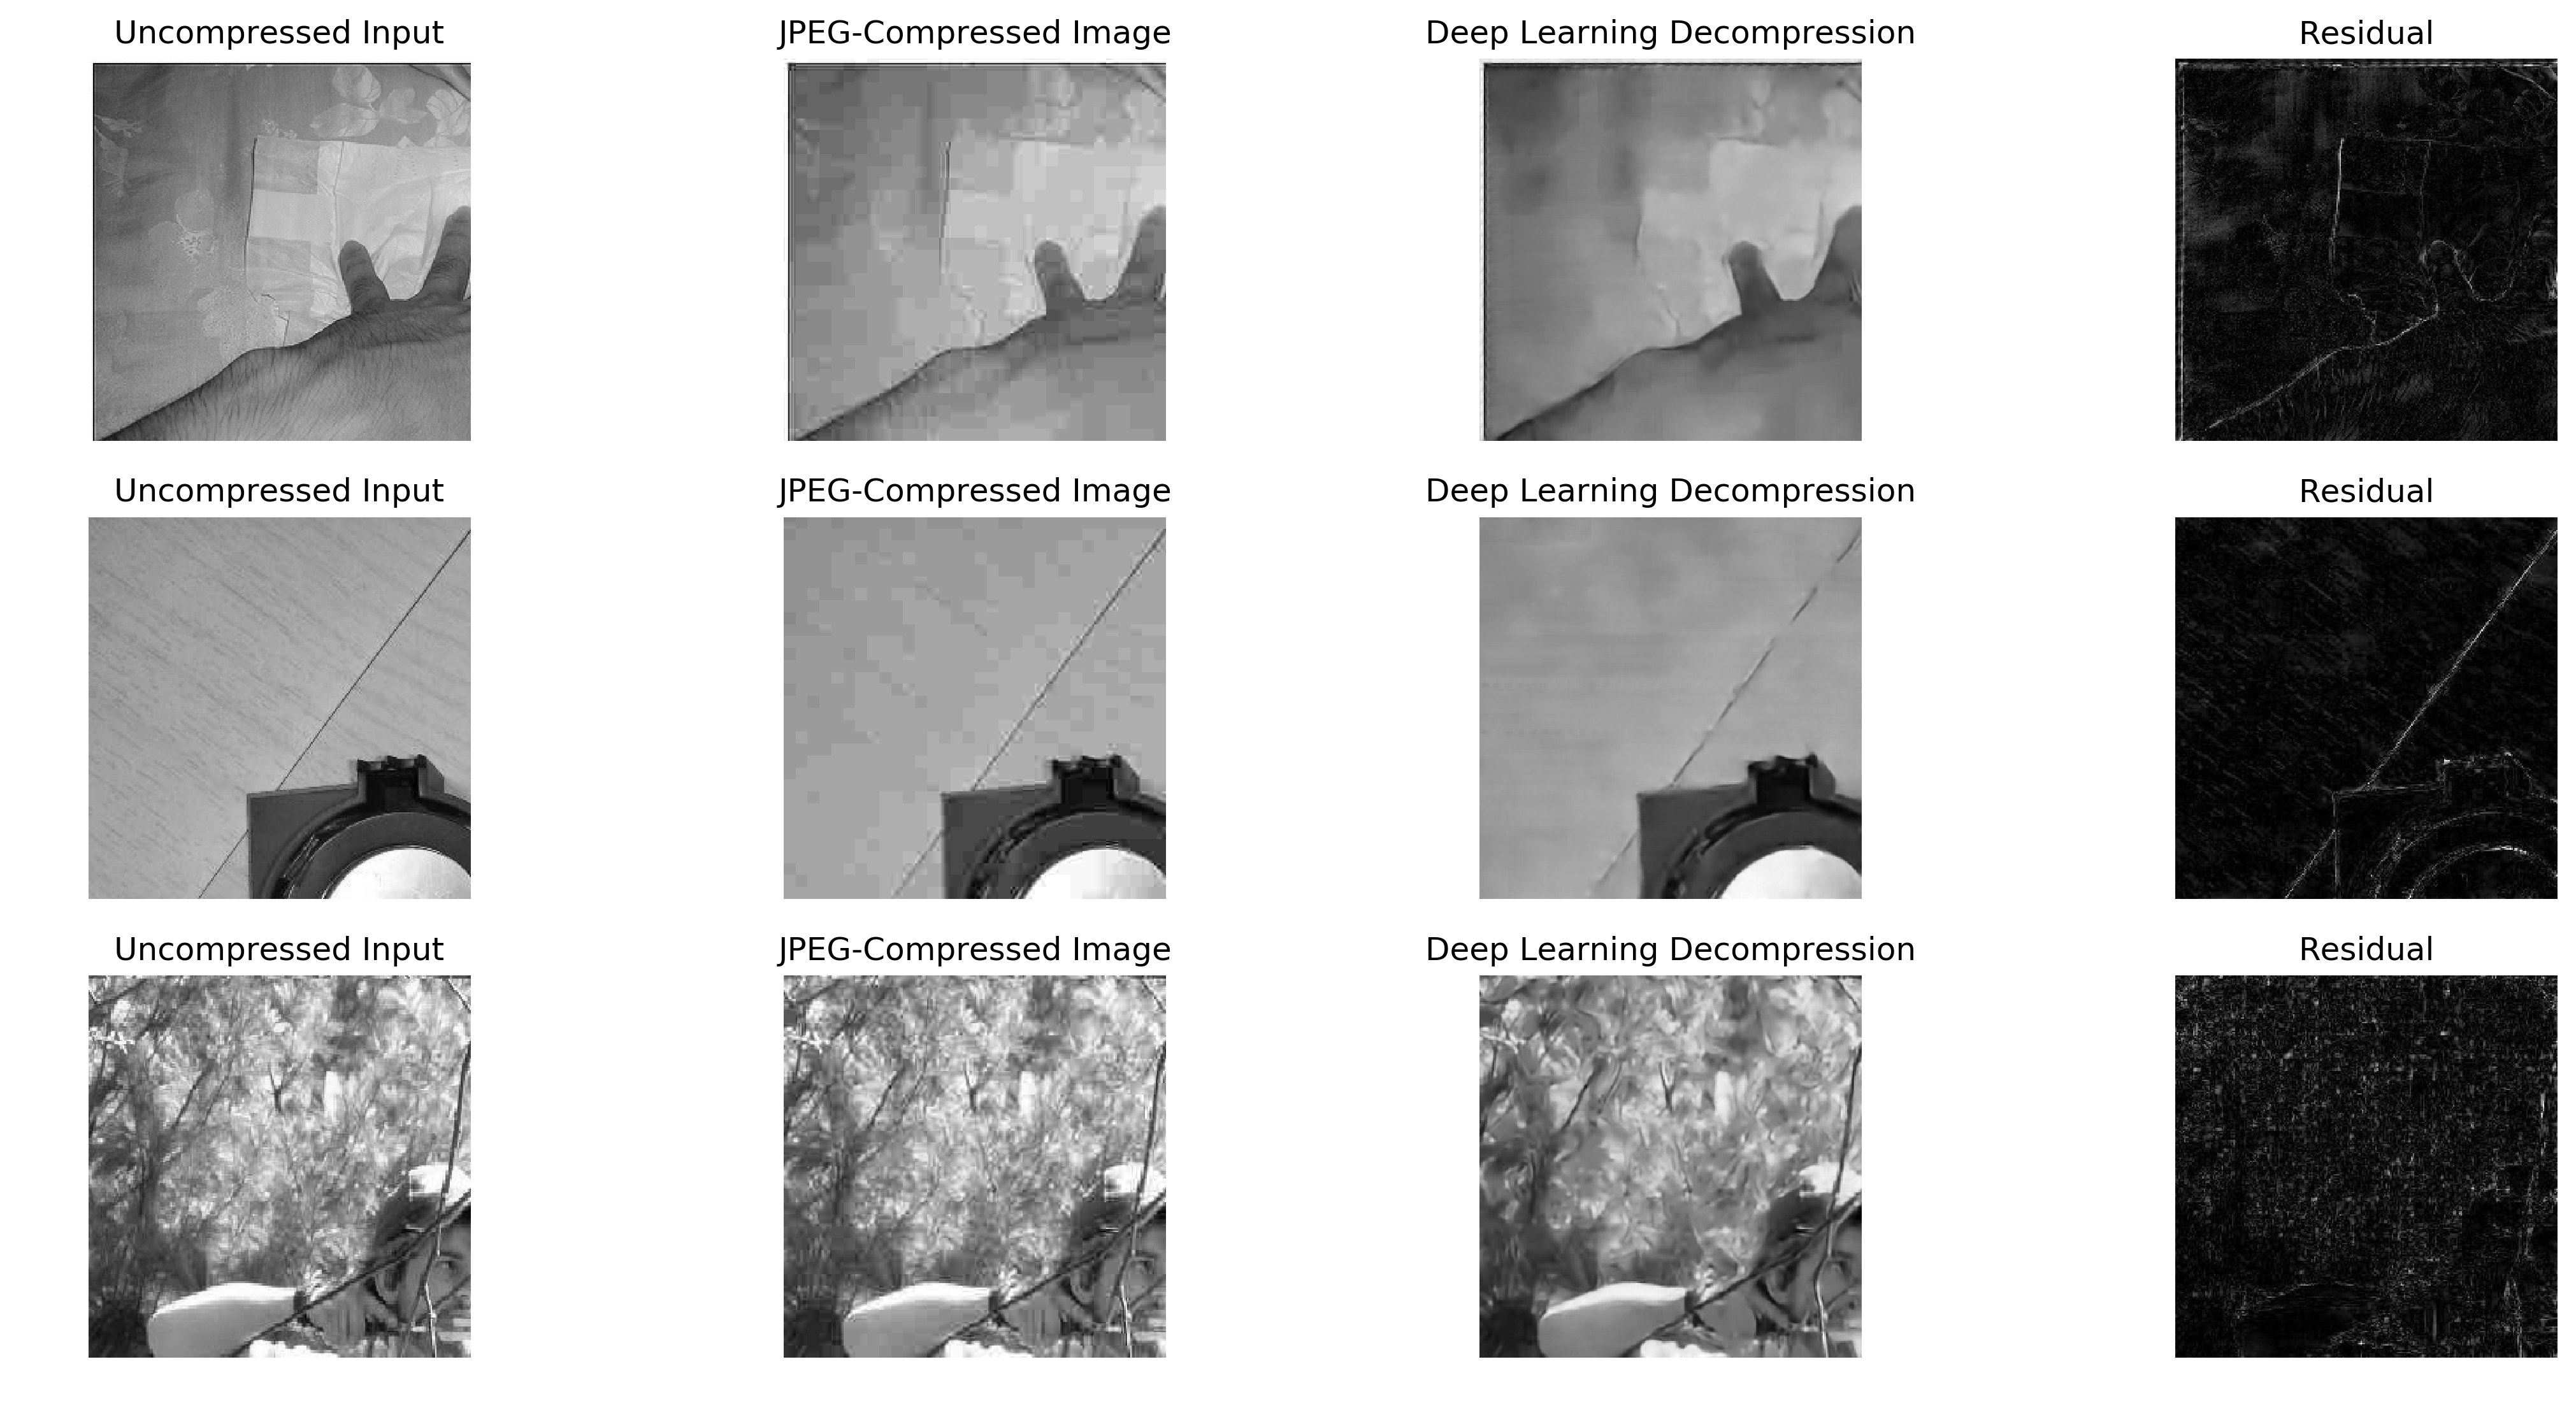

In [22]:
print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Input")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Image")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(pred[0][indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Deep Learning Decompression")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0]-pred[0][indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

In [23]:
metr = calculate_metrics(test_unc, pred[0])
print('\n')
metr = calculate_metrics(test_unc, pred[1])

(3627, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


removing 1200 NRMSE from list.
removing 2512 NRMSE from list.
(3625, 3, 2)

Performance Metrics
SSIM: 0.760 +/- 0.124
PSNR: 26.436 +/- 3.790
NRMSE: 5.354 +/- 2.468


(3627, 3, 2)
removing 1200 NRMSE from list.
removing 2512 NRMSE from list.
(3625, 3, 2)

Performance Metrics
SSIM: 0.251 +/- 0.111
PSNR: 12.201 +/- 2.509
NRMSE: 22.250 +/- 9.815


# =============================================================
<a name='networkc'/>

# Network C: DCT-Image Domain Fully-Connected U-net

A Fully-Connected network in the DCT domain and a U-net operating in the image domain are concatenated such that the result of the Fully-Connected network is the input to the image-domain U-net in an end-to-end fashion.

Data consistency measures are taken by ensuring that the DCT coefficients predicted by either U-nets are not outside the allowed quantization values:

$$X_{reconstruction} \in [X_{JPEG} - \frac{Q}{2} , X_{JPEG} + \frac{Q}{2}]$$

where: <br><br>
$X_{reconstruction}$ is the deep learning reconstructed image,<br>
$X_{JPEG}$ is the JPEG-decompressed image,<br>
$Q$ is the JPEG quality factor

In [11]:
opt=Adam(lr=lr)
model_name = "../Models/20190614-MRDataset-residual_fc_unet_fi_data_augmentation_compress_10_20.hdf5"
model = deep_cascade_fc_unet(depth_str='fi')
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)
model.summary()

0 f
Instructions for updating:
Use tf.cast instead.
Append DCT layer (patches)
Append FC/dense block
Append data consistency block
Append iDCT layer (patches)
1 i
Append U-net block
Append DCT layer (patches)
Append data consistency block
Append iDCT layer (patches)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 8, 8, 1)      0           input_5[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 64)           0           lambda_3[0][0]                   
________________________________________

In [12]:
pred = model.predict([norm_test_compr,test_qmat])

In [13]:
# Un-normalize

pred[0] *= norm
pred[0] += norm

pred[1] *= norm
pred[1] += norm

0.0 193.0
-1.0986328 172.27316


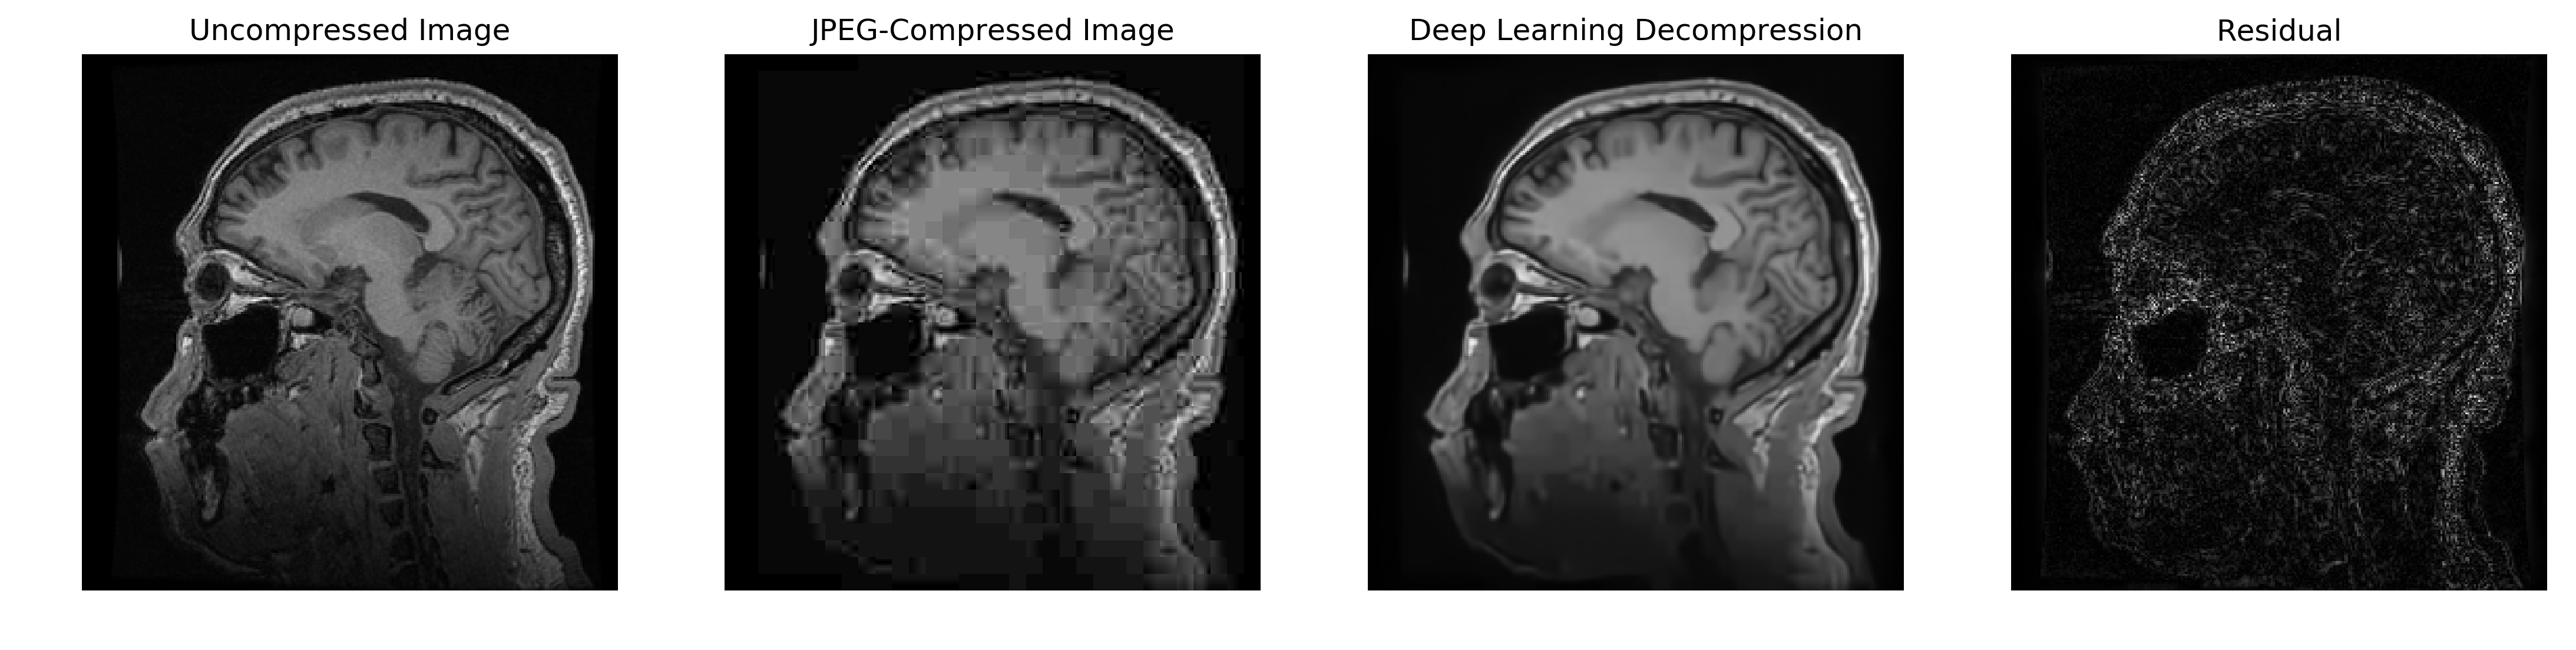

In [22]:
print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(pred[0][slc,:,:,0]),np.max(pred[0][slc,:,:,0]))

plt.figure(figsize = (18,12),dpi=300)
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Deep Learning Decompression")
plt.imshow(pred[0][slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - pred[0][slc,:,:,0]),cmap = "gray")
plt.show()

In [15]:
print(np.sum((pred[0][slc,:,:,0] - test_unc[slc,:,:,0])**2) / pred[0][slc,:,:,0].size)

26.595075607299805


Test set results


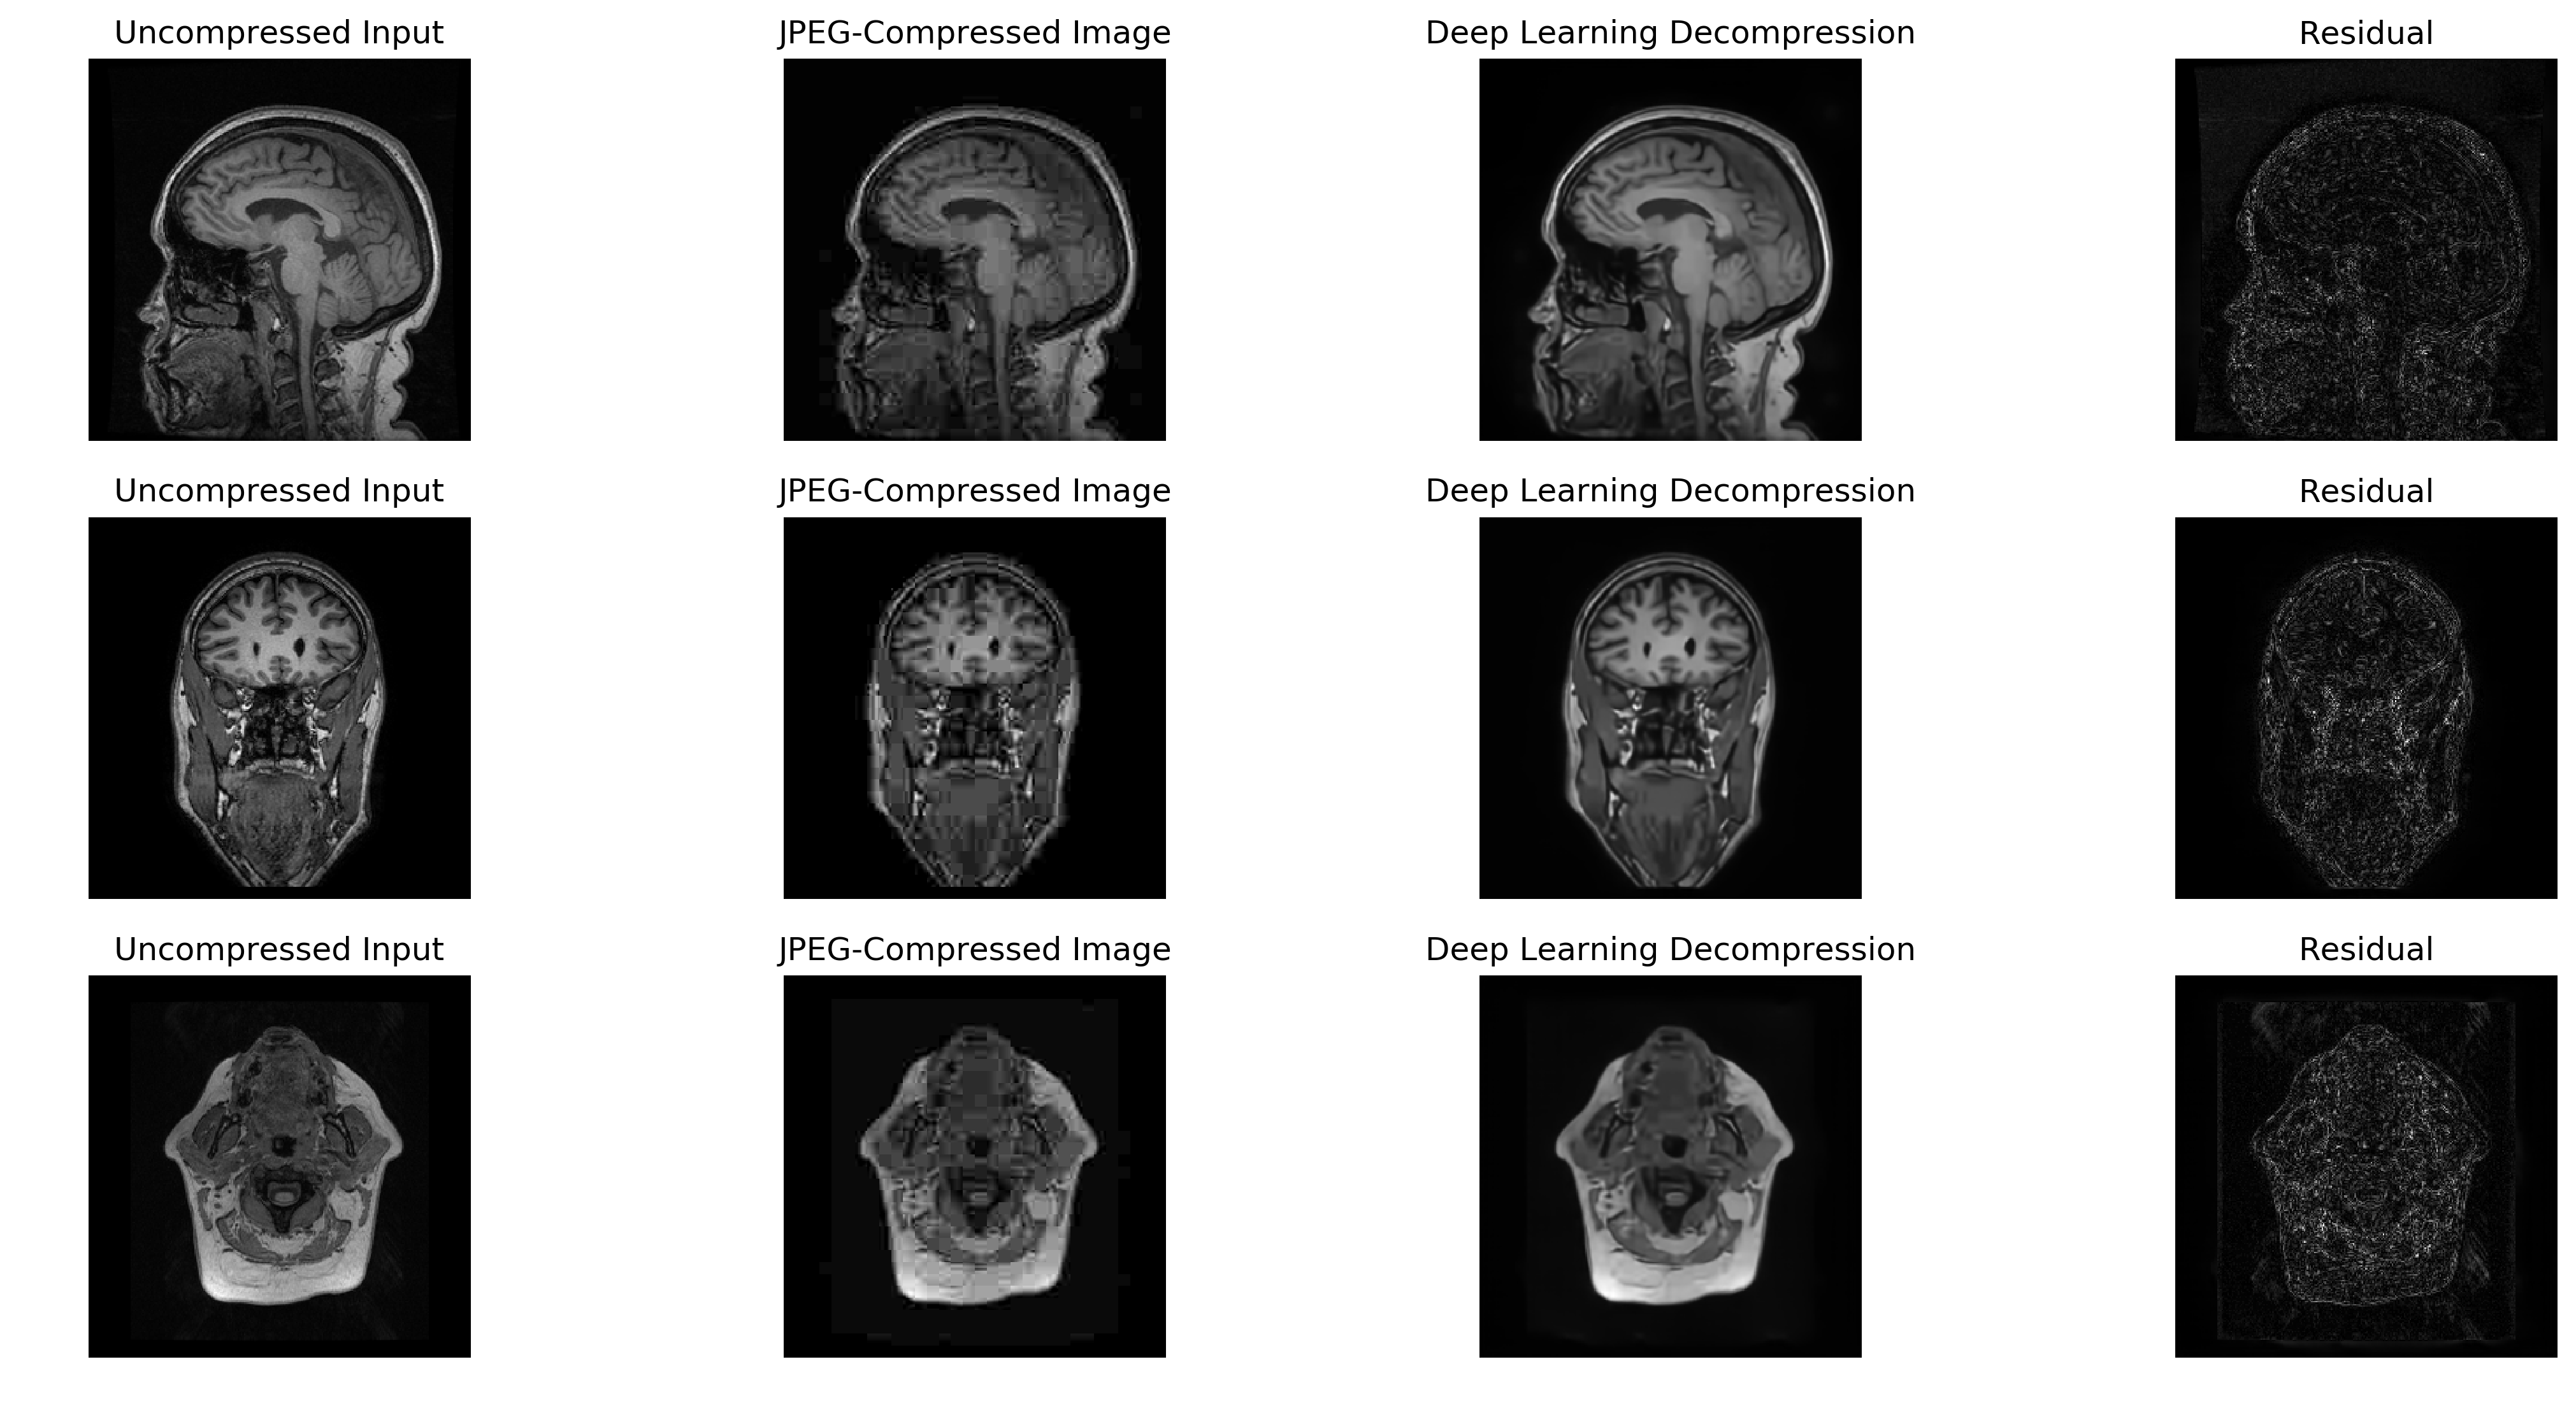

In [23]:
print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    plt.subplot(3,4,4*ii+1)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Input")
    plt.subplot(3,4,4*ii+2)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Image")
    plt.subplot(3,4,4*ii+3)
    plt.imshow(pred[0][indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Deep Learning Decompression")
    plt.subplot(3,4,4*ii+4)
    plt.imshow(abs(test_unc[indexes_test[ii],:,:,0]-pred[0][indexes_test[ii],:,:,0]),cmap = "gray")
    plt.axis("off")
    plt.title("Residual")
plt.show()     

In [17]:
metr = calculate_metrics(test_unc, pred[0])
print('\n')
metr = calculate_metrics(test_unc, pred[1])

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(compare_mse(im_true, im_test)) / denom


removing 659 NRMSE from list.
removing 990 NRMSE from list.
removing 6077 NRMSE from list.
removing 6167 NRMSE from list.
removing 7022 NRMSE from list.
removing 7589 NRMSE from list.
removing 8104 NRMSE from list.
(16103, 3, 2)

Performance Metrics
SSIM: 0.812 +/- 0.108
PSNR: 29.771 +/- 2.663
NRMSE: 3.133 +/- 1.774


(16110, 3, 2)
removing 659 NRMSE from list.
removing 990 NRMSE from list.
removing 6077 NRMSE from list.
removing 6167 NRMSE from list.
removing 7022 NRMSE from list.
removing 7589 NRMSE from list.
removing 8104 NRMSE from list.
(16103, 3, 2)

Performance Metrics
SSIM: 0.783 +/- 0.086
PSNR: 28.913 +/- 3.023
NRMSE: 3.501 +/- 1.385


# =============================================================
<a name='scratchpad'/>

# Scratchpad

In [9]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Lambda, Add, Subtract, LeakyReLU, \
                         MaxPooling2D, concatenate, UpSampling2D,\
                         Multiply, Dense, Flatten, Reshape


def tf_dct2d(im):
    return K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im,type=2,axis=-1,norm='ortho'),perm=[0,2,1,3]),type=2,axis=-1,norm='ortho'),perm=[0,2,1,3])
    
    
def tf_idct2d(mat): 
    return K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(mat,type=2,axis=-1,norm='ortho'),perm=[0,2,1,3]),type=2,axis=-1,norm='ortho'),perm=[0,2,1,3])


# Modified from:
# https://www.programcreek.com/python/example/90422/tensorflow.extract_image_patches
def extract_patches(x, patsize=(1,8,8,1), strides=(1,8,8,1), rates=(1,1,1,1)):
    patches = K.tf.extract_image_patches(
        x,
        patsize,
        strides,
        rates,
        padding="SAME"
    )
    patches_shape = K.tf.shape(patches)
    return K.tf.reshape(patches, 
                      [K.tf.reduce_prod(patches_shape[0:3]), 
                       8, 8, 1])  # returns [batch_patches, h, w, c] 


# x = orig
# y = orig in patches
def extract_patches_inverse(x, y):
    _x = K.tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = K.tf.gradients(_y, _x)[0]
    # Divide by grad, to "average" together the overlapping patches
    # otherwise they would simply sum up
    return K.tf.gradients(_y, _x, grad_ys=y)[0] / grad


def dct_layer(image):
    """
    Input: single channel array representing image domain data
    Output: single channel array representing dct coefficient data
    """
    
    patches = extract_patches(image)
    dct_patches = tf_dct2d(patches)
    dct_image = extract_patches_inverse(image, dct_patches)
    
    return dct_image


def idct_layer(dctdata):
    """
    Input: a list of input data. See below
    Output: single channel array representing image domain data
    
    data_list: data_list[0] = dct matrix (in patches) [total_num_patches, patch_size, patch_size, chnl]
               data_list[1] = single channel image in original dimensions [batch, H, W, chnl]
    """
    
    patches = extract_patches(dctdata)
    image_patches = tf_idct2d(patches)
    image = extract_patches_inverse(dctdata, image_patches)
    
    return image


def dct_dc_layer(data_list): #, dctmat, jpeg_dctmat, qmat):
    """
    param data_list: data_list[0] = dct matrix; 
                     data_list[1] = jpeg-compressed dct matrix; 
                     data_list[2] = quantization matrix
    
    
    param dctmat: quantization matrix for each image
    param jpeg_dctmat: single channel array representing dct coefficient data
    param qmat: quantization matrix
    Output: dct coefficients restricted to range
    """
    # Clip range: X_recon = [(X_jpeg*Q - Q/2), (X_jpeg*Q + Q/2)]

    clip_low = Subtract()([data_list[1], data_list[2] * 0.5])
    clip_high = Add()([data_list[1], data_list[2] * 0.5])
    return K.tf.clip_by_value(data_list[0], clip_low, clip_high)

    #return K.tf.clip_by_value(dctmat, clip_low, clip_high)
    

def fft_layer(image):
    """
    Input: 2-channel array representing image domain complex data
    Output: 2-channel array representing k-space complex data
    """

    # get real and imaginary portions
    real = Lambda(lambda image: image[:, :, :, 0])(image)
    imag = Lambda(lambda image: image[:, :, :, 1])(image)

    image_complex = K.tf.complex(real, imag)  # Make complex-valued tensor
    kspace_complex = K.tf.fft2d(image_complex)

    # expand channels to tensorflow/keras format
    real = K.tf.expand_dims(K.tf.real(kspace_complex), -1)
    imag = K.tf.expand_dims(K.tf.imag(kspace_complex), -1)

    # generate 2-channel representation of k-space
    kspace = K.tf.concat([real, imag], -1)
    
    return kspace


def ifft_layer(kspace_2channel):
    """
    Input: 2-channel array representing k-space
    Output: 2-channel array representing image domain
    """
    #get real and imaginary portions
    real = Lambda(lambda kspace_2channel : kspace_2channel[:,:,:,0])(kspace_2channel)
    imag = Lambda(lambda kspace_2channel : kspace_2channel[:,:,:,1])(kspace_2channel)
    
    kspace_complex = K.tf.complex(real,imag) # Make complex-valued tensor
    image_complex = K.tf.ifft2d(kspace_complex)
    
    # expand channels to tensorflow/keras format
    real = K.tf.expand_dims(K.tf.real(image_complex),-1)
    imag = K.tf.expand_dims(K.tf.imag(image_complex),-1)
    
    # generate 2-channel representation of image domain
    image_complex_2channel = K.tf.concat([real, imag], -1)
    return image_complex_2channel


def rfft_layer(image):
    """
    Input: single-channel array representing image domain real data
    Output: 2-channel array representing k-space complex data
    """

    empty = K.tf.zeros_like(image)
    image_complex = K.tf.complex(image,empty)
    
    kspace_complex = K.tf.signal.fft2d(image_complex)
    print(K.tf.shape(kspace_complex))
        
    real = K.tf.real(kspace_complex)
    imag = K.tf.imag(kspace_complex)

    # generate 2-channel representation of k-space
    kspace = K.tf.concat([real, imag], -1)

    return kspace


def abs_layer(complex_data):
    """
    Input: 2-channel array representing complex data
    Output: 1-channel array representing magnitude of complex data
    """
    #get real and imaginary portions
    real = Lambda(lambda complex_data : complex_data[:,:,:,0])(complex_data)
    imag = Lambda(lambda complex_data : complex_data[:,:,:,1])(complex_data)
    
    mag = K.tf.abs(K.tf.complex(real,imag))
    mag = K.tf.expand_dims(mag, -1)
    return mag


def fc_dct_layer(image):
    """
    Input: single channel array representing image domain data
    Output: single channel array representing dct coefficient data (in patches)
    """
    
    patches = extract_patches(image)
    dct_patches = tf_dct2d(patches)
    
    return dct_patches


def fc_idct_layer(data_list):
    """
    Input: single channel array representing dct coefficient data (in patches)
    Output: single channel array representing image domain data
    
    data_list: data_list[0] = dct matrix (in patches) [total_num_patches, patch_size, patch_size, chnl]
               data_list[1] = single channel image in original dimensions [batch, H, W, chnl]
    """
    
    image_patches = tf_idct2d(data_list[0])
    image = extract_patches_inverse(data_list[1], image_patches)
    
    return image


def fc_fft_layer(image):
    """
    Input: single-channel array representing image domain real data
    Output: 2-channel array representing k-space complex data
    """
    
    #real = Lambda(lambda image: image[:, :, :, 0])(image)
    #imag = Lambda(lambda image: image[:, :, :, 1])(image)
    
    image_pat = Lambda(extract_patches)(image)
    empty = K.tf.zeros_like(image_pat)
    
    image_complex_pat = K.tf.complex(image_pat,empty)
    
    kspace_complex = K.tf.signal.fft2d(image_complex_pat)
    print(K.tf.shape(kspace_complex))
        
    real = K.tf.real(kspace_complex)
    imag = K.tf.imag(kspace_complex)

    # generate 2-channel representation of k-space
    kspace = K.tf.concat([real, imag], -1)

    return kspace


def dense_block(dense_input):
    
    inputs_flat = Flatten()(dense_input)
    
    dense1 = Dense(64, input_shape=(64,), activation='tanh')(inputs_flat)
    dense2 = Dense(64, activation='tanh')(dense1)
    dense3 = Dense(128, activation='tanh')(dense2)
    dense4 = Dense(128, activation='tanh')(dense3)
    dense5 = Dense(256, activation='tanh')(dense4)
    dense6 = Dense(256, activation='tanh')(dense5)
    dense7 = Dense(128, activation='tanh')(dense6)
    dense8 = Dense(128, activation='tanh')(dense7)
    dense9 = Dense(64, activation='tanh')(dense8)
    last_dense = Dense(64, activation='tanh')(dense9)

    #output_layer = Reshape(8,8)(dense4)
    output_layer = Reshape((8,8,1), input_shape=(64,))(last_dense)
    
    return output_layer


def unet_block(unet_input, kshape=(3, 3)):
    """
    :param unet_input: Input layer
    :param kshape: Kernel size
    :return: single channel
    """

    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(unet_input)
    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(conv3)
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(conv4)
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(conv4)

    up1 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(up1)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(conv5)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(conv5)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(up2)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(conv6)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(conv6)

    up3 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(up3)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(conv7)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(conv7)

    conv8 = Conv2D(1, (1, 1), activation='linear')(conv7)
    out = Add()([conv8, unet_input])
    return out


def unet_block_2chnl(unet_input, kshape=(3, 3)):
    """
    :param unet_input: Input layer
    :param kshape: Kernel size
    :return: 2-channel, complex reconstruction
    """

    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(unet_input)
    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(conv3)
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(conv4)
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(conv4)

    up1 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(up1)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(conv5)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(conv5)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(up2)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(conv6)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(conv6)

    up3 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(up3)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(conv7)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(conv7)

    conv8 = Conv2D(2, (1, 1), activation='linear')(conv7)
    out = Add()([conv8, unet_input])
    return out


def deep_cascade_unet(depth_str='di', H=256, W=256, kshape=(3, 3), useDC = True):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model
    """

    channels = 1  # inputs are represented as single channel images (grayscale)
    inputs = Input(shape=(H, W, channels))
    qmat = Input(shape=(H, W, channels))
    layers = [inputs]
    dct_flag = False # flag whether input is in the image domain (false) or dct domain (true)
    kspace_flag = False
    
    # intermed_list = []

    for (jj,ii) in enumerate(depth_str):
        print(jj, ii)
        if ii == 'd':
            if not dct_flag: # if in image domain
                # Apply DCT 
                layers.append(Lambda(dct_layer)(layers[-1])) 
                print("Append DCT layer")
                dct_flag = True
        elif ii == 'k':
            if not kspace_flag: # if in image domain
                # Apply FFT 
                print("Append rFFT layer")
                layers.append(Lambda(rfft_layer)(layers[-1])) 
                kspace_flag = True
        elif ii == 'i':
            if dct_flag: # if in dct domain
                layers.append(Lambda(idct_layer)(layers[-1])) 
                print("Append iDCT layer")
                dct_flag = False
            if kspace_flag: # if in k-space
                print("Append iFFT layer")
                layers.append(Lambda(ifft_layer)(layers[-1]))
                print("Append magnitude layer")
                layers.append(Lambda(abs_layer)(layers[-1]))
                kspace_flag = False
        else:
            print("Layer not recognized. Only 'd', 'k', and 'i' layers are currently supported.")
            break;

        if kspace_flag:
            # Append 2-channel U-net block
            layers.append(unet_block_2chnl(layers[-1], kshape))
            print("Append U-net (2-channel) block")
        else:
            # Append 1-channel U-net block
            layers.append(unet_block(layers[-1], kshape))
            print("Append U-net block")
        
        if useDC:
            # Append a data consistency layer
            print("Data consistency layer")
            if dct_flag: # if in the DCT domain
                print("Currently in the DCT domain")
                print("Append DC layer")
                print("Append iDCT layer")
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs, qmat]))
                intermed = Lambda(idct_layer)(layers[-1])
                layers.append(intermed)
                dct_flag = False
            elif kspace_flag: # if in k-space
                print("Currently in the FFT domain")
                print("Append iFFT-abs layers")
                print("Append DCT-DC-iDCT layers")
                layers.append(Lambda(ifft_layer)(layers[-1]))
                layers.append(Lambda(abs_layer)(layers[-1]))
                layers.append(Lambda(dct_layer)(layers[-1])) 
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs, qmat]))
                intermed = Lambda(idct_layer)(layers[-1])
                layers.append(intermed)
                kspace_flag = False
            else: # if in the image domain
                print("Currently in the image domain")
                print("Append DCT-DC-iDCT layers")
                layers.append(Lambda(dct_layer)(layers[-1])) 
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs, qmat]))
                layers.append(Lambda(idct_layer)(layers[-1])) 
            
        if not (jj + 1) % len(depth_str) > 0: # check if there is a next element
            if dct_flag: # if in DCT domain
                layers.append(Lambda(idct_layer)(layers[-1])) 
                print("Append iDCT layer")
                dct_flag = False
            elif kspace_flag: # if in k-space
                print("Append iFFT layer")
                layers.append(Lambda(ifft_layer)(layers[-1]))
                print("Append magnitude layer")
                layers.append(Lambda(abs_layer)(layers[-1]))
                kspace_flag = False
            
        #intermed_list = [intermed_list, intermed]
        
    if useDC:
        outputs = [layers[-1], intermed]
    else:
        outputs = [layers[-1], layers[1]]
    
    model = Model(inputs=[inputs,qmat], outputs=outputs)
    return model


# NEED TO FIX:
# Don't append iDCT layer for cases like 'ff'
def deep_cascade_fc_unet(depth_str='fi', H=256, W=256, kshape=(3, 3)):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model
    """

    channels = 1  # inputs are represented as single channel images (grayscale)
    inputs = Input(shape=(H, W, channels))
    qmat = Input(shape=(H, W, channels))
    
    qmat_pat = Lambda(extract_patches)(qmat)
    inputs_pat = Lambda(extract_patches)(inputs)
    
    layers = [inputs]
    fc_flag = False # flag whether input is in the image domain (false) or dct domain (true)
                    # i.e. input is in image domain
    
    for (jj,ii) in enumerate(depth_str):
        print(jj,ii)
        if ii == 'f':
            if not fc_flag: # image domain
                layers.append(Lambda(fc_dct_layer)(layers[-1]))
                print("Append DCT layer (patches)")
                layers.append(dense_block(layers[-1]))
                print("Append FC/dense block")
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat_pat]))
                print("Append data consistency block")
                intermed = Lambda(fc_idct_layer)([layers[-1], inputs])
                layers.append(intermed)
                print("Append iDCT layer (patches)")
                fc_flag = True
            else: # DCT domain
                layers.append(dense_block(layers[-1]))
                print("Append FC/dense block")
        elif ii == 'i':
            if not fc_flag: # image domain
                layers.append(unet_block(layers[-1], kshape))
                print("Append U-net block")
                layers.append(Lambda(fc_dct_layer)(layers[-1]))
                print("Append DCT layer (patches)")
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat_pat]))
                print("Append data consistency block")
                layers.append(Lambda(fc_idct_layer)([layers[-1], inputs]))
                print("Append iDCT layer (patches)")
                fc_flag = False
            else: # DCT domain
                #layers.append(Lambda(fc_idct_layer)([layers[-1], inputs])) 
                #print("Append iDCT layer (patches)")
                layers.append(unet_block(layers[-1], kshape))
                print("Append U-net block")
                layers.append(Lambda(fc_dct_layer)(layers[-1]))
                print("Append DCT layer (patches)")
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat_pat]))
                print("Append data consistency block")
                layers.append(Lambda(fc_idct_layer)([layers[-1], inputs]))
                print("Append iDCT layer (patches)")
                fc_flag = False
        else:
            print("Layer not recognized. Only 'f' and 'i' layers are currently supported.")
            break;
            
        if not ((jj + 1) % len(depth_str) > 0) and ii == 'f' and fc_flag:
            layers.append(Lambda(fc_idct_layer)([layers[-1], inputs])) 
            print("Append iDCT layer (patches)")
    

    model = Model(inputs=[inputs,qmat], outputs=[layers[-1],intermed])
    return model


def deep_cascade_fc_ksp_unet(depth_str='fi', H=256, W=256, kshape=(3, 3)):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model
    """

    channels = 1  # inputs are represented as single channel images (grayscale)
    inputs = Input(shape=(H, W, channels))
    qmat = Input(shape=(H, W, channels))
    
    qmat_pat = Lambda(extract_patches)(qmat)
    inputs_pat = Lambda(extract_patches)(inputs)
    
    layers = [inputs]
    fc_flag = False # flag whether input is in the image domain (false) or dct domain (true)
                    # i.e. input is in image domain
    
    for (jj,ii) in enumerate(depth_str):
        print(jj,ii)
        if ii == 'f':
            if not fc_flag: # image domain
                layers.append(Lambda(fc_dct_layer)(layers[-1]))
                print("Append DCT layer (patches)")
                layers.append(dense_block(layers[-1]))
                print("Append FC/dense block")
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat_pat]))
                print("Append data consistency block")
                intermed = Lambda(fc_idct_layer)([layers[-1], inputs])
                layers.append(intermed)
                print("Append iDCT layer (patches)")
                fc_flag = True
            else: # DCT domain
                layers.append(dense_block(layers[-1]))
                print("Append FC/dense block")
        elif ii == 'i':
            if not fc_flag: # image domain
                layers.append(unet_block(layers[-1], kshape))
                print("Append U-net block")
                layers.append(Lambda(fc_dct_layer)(layers[-1]))
                print("Append DCT layer (patches)")
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat_pat]))
                print("Append data consistency block")
                layers.append(Lambda(fc_idct_layer)([layers[-1], inputs]))
                print("Append iDCT layer (patches)")
                fc_flag = False
            else: # DCT domain
                #layers.append(Lambda(fc_idct_layer)([layers[-1], inputs])) 
                #print("Append iDCT layer (patches)")
                layers.append(unet_block(layers[-1], kshape))
                print("Append U-net block")
                layers.append(Lambda(fc_dct_layer)(layers[-1]))
                print("Append DCT layer (patches)")
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat_pat]))
                print("Append data consistency block")
                layers.append(Lambda(fc_idct_layer)([layers[-1], inputs]))
                print("Append iDCT layer (patches)")
                fc_flag = False
        else:
            print("Layer not recognized. Only 'f' and 'i' layers are currently supported.")
            break;
            
        if not ((jj + 1) % len(depth_str) > 0) and ii == 'f' and fc_flag:
            layers.append(Lambda(fc_idct_layer)([layers[-1], inputs])) 
            print("Append iDCT layer (patches)")
    

    model = Model(inputs=[inputs,qmat], outputs=[layers[-1],intermed])
    return model

In [24]:
# See intermediate layer results
layer1 = model.get_layer("lambda_3").output
intermed = Model(inputs=model.inputs, outputs=layer1)
test = intermed.predict([norm_test_compr, test_qmat])

# test *= norm
# test += norm

In [26]:
test *= norm
test += norm

13.0 248.0
20.735626 239.39299


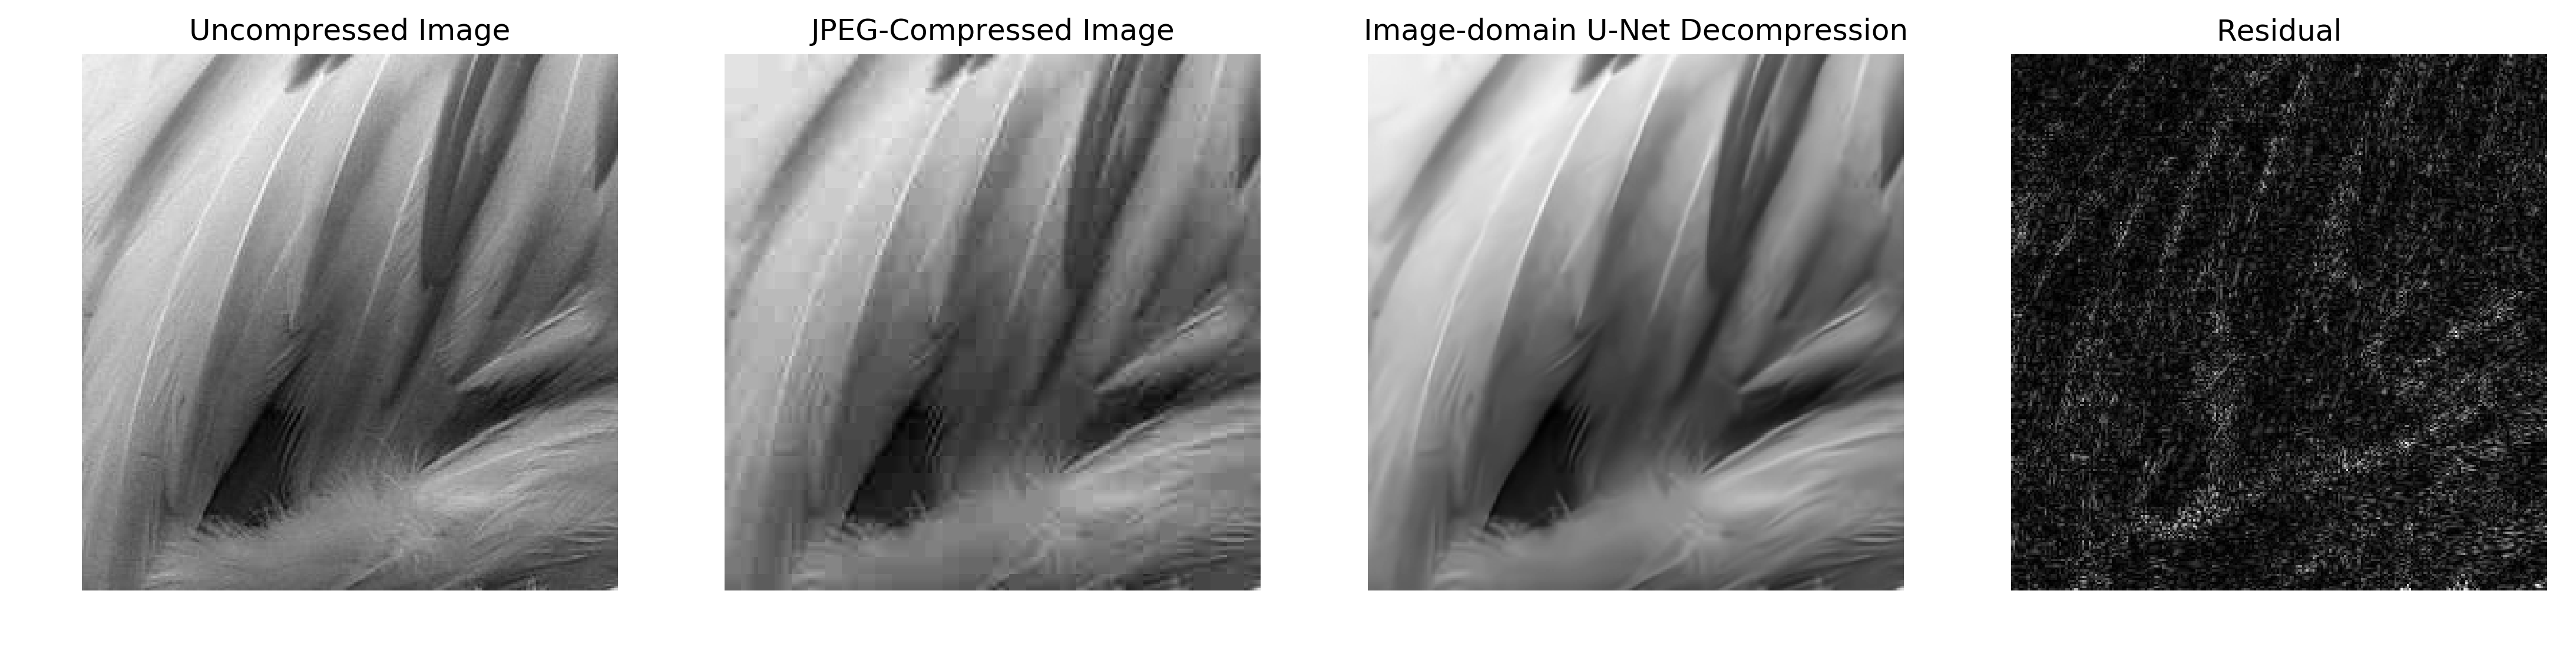

In [27]:
print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(test[slc,:,:,0]),np.max(test[slc,:,:,0]))

plt.figure(figsize = (18,12),dpi=300)
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Deep Learning Decompression")
plt.imshow(test[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - test[slc,:,:,0]),cmap = "gray")
plt.show()

In [28]:
print(np.sum((test[slc,:,:,0] - test_unc[slc,:,:,0])**2) / test[slc,:,:,0].size)

23.58843421936035
